<a href="https://colab.research.google.com/github/ARUNAGIRINATHAN-K/Retail-Transaction-Analytics/blob/main/Basket_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset

In [62]:
df = pd.read_csv("/content/Retail_pos_basket_data.csv.csv", parse_dates=["order_date"])

# 1. Data Overview

In [63]:
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nMissing Values:\n", df.isnull().sum())
print("\nUnique Products:", df['product_name'].nunique())
print("Unique Categories:", df['category'].nunique())
print("Unique Customers:", df['user_id'].nunique())

Shape: (10000, 10)

Columns: ['order_id', 'user_id', 'order_date', 'time', 'order_hour_of_day', 'product_name', 'quantity', 'price', 'category', 'product_id']

Missing Values:
 order_id             0
user_id              0
order_date           0
time                 0
order_hour_of_day    0
product_name         0
quantity             0
price                0
category             0
product_id           0
dtype: int64

Unique Products: 68
Unique Categories: 17
Unique Customers: 488


# 2. Create Sales Column

In [64]:
df["sales"] = df["quantity"] * df["price"]

# 3. Sales Overview

In [65]:
print("\nTotal Revenue:", df["sales"].sum())
print("Average Basket Size:", df.groupby("order_id")["product_id"].count().mean())


Total Revenue: 5160106.359999999
Average Basket Size: 5.022601707684581


# Top Products

In [66]:

top_products = df.groupby("product_name")["sales"].sum().sort_values(ascending=False).head(10)
print("\nTop Products:\n", top_products)


Top Products:
 product_name
Chocolate       92478.01
Soda            89461.60
Shoes           86876.56
Cookies         85253.18
Prawns          85090.57
Energy Drink    84184.32
Tissue          83491.86
Milk            83374.09
Belt            83161.02
Chips           82316.26
Name: sales, dtype: float64


# Top Customers

In [67]:
top_customers = df.groupby("user_id")["sales"].sum().sort_values(ascending=False).head(10)
print("\nTop Customers:\n", top_customers)


Top Customers:
 user_id
53     33832.72
329    33783.09
40     30118.58
367    29082.20
234    24915.38
7      24180.48
374    24028.65
273    23941.90
173    23850.25
485    23513.67
Name: sales, dtype: float64


# 4. Category-Level Analysis

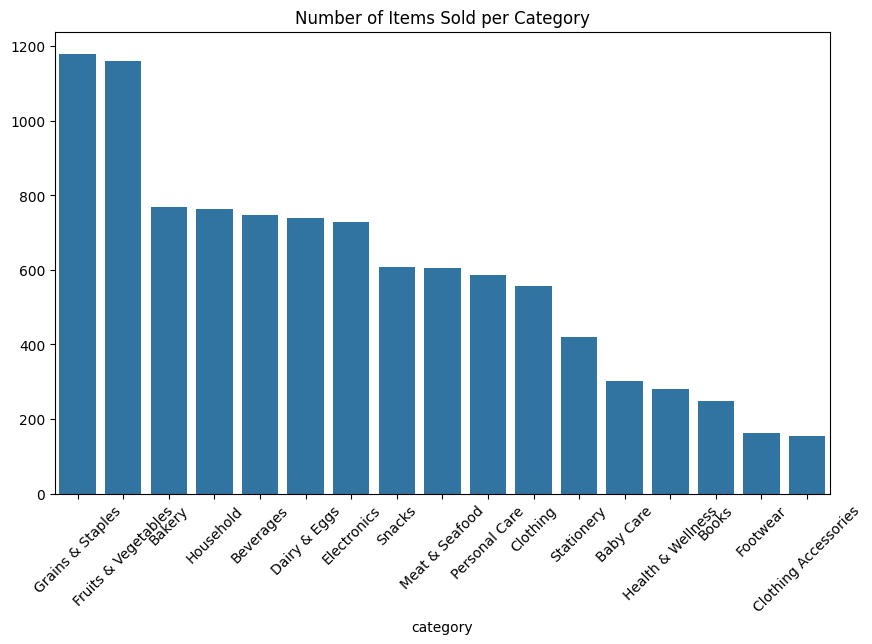

In [68]:
plt.figure(figsize=(10,6))
sns.barplot(x=df["category"].value_counts().index, y=df["category"].value_counts().values)
plt.xticks(rotation=45)
plt.title("Number of Items Sold per Category")
plt.show()

# 5. Time-Based Analysis

# By Month

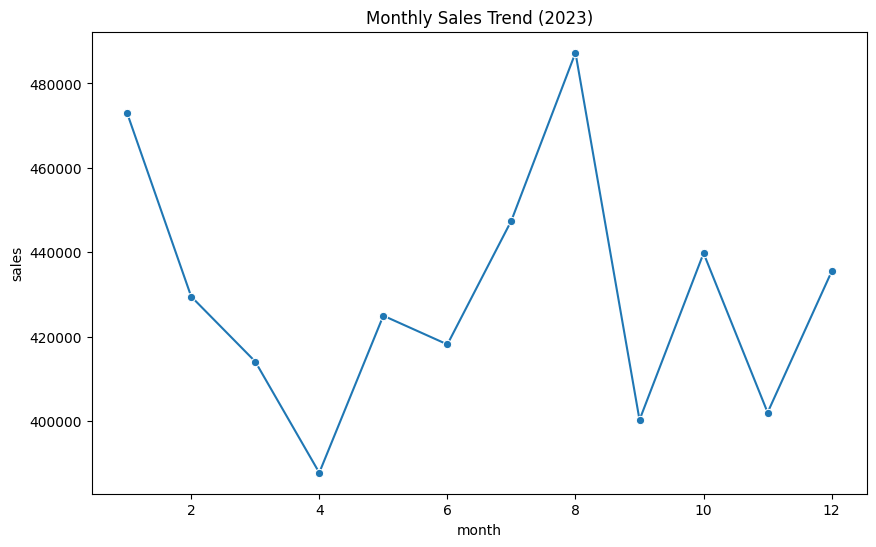

In [69]:
df["month"] = df["order_date"].dt.month
plt.figure(figsize=(10,6))
sns.lineplot(x="month", y="sales", data=df.groupby("month")["sales"].sum().reset_index(), marker="o")
plt.title("Monthly Sales Trend (2023)")
plt.show()

# By Hour

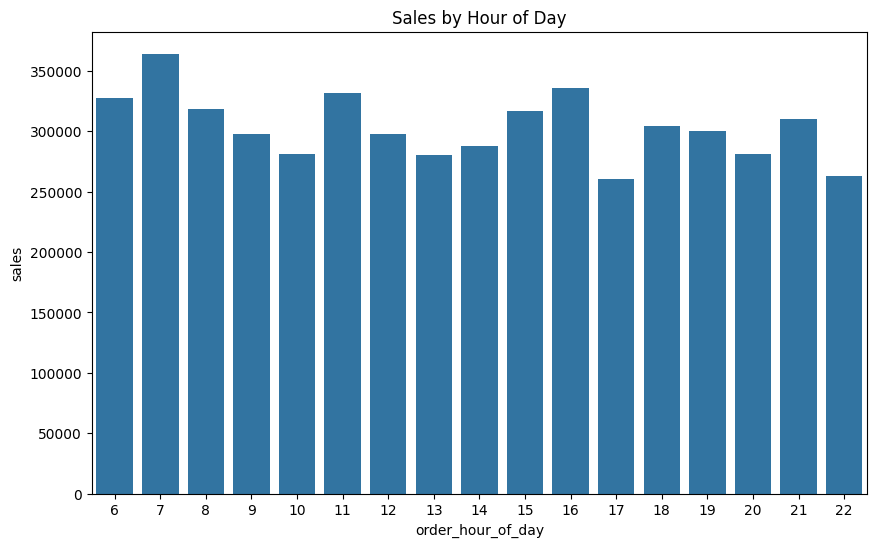

In [70]:
plt.figure(figsize=(10,6))
sns.barplot(x="order_hour_of_day", y="sales", data=df.groupby("order_hour_of_day")["sales"].sum().reset_index())
plt.title("Sales by Hour of Day")
plt.show()

# 6. Price & Quantity Distribution

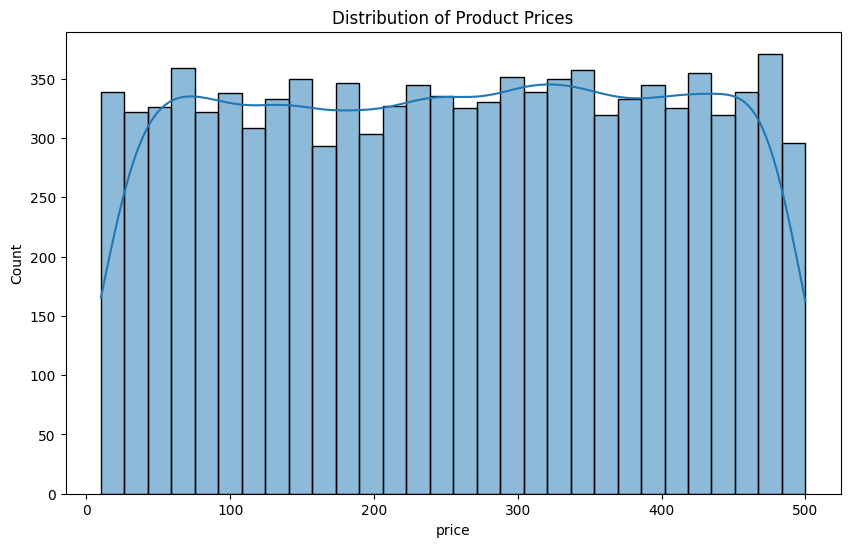

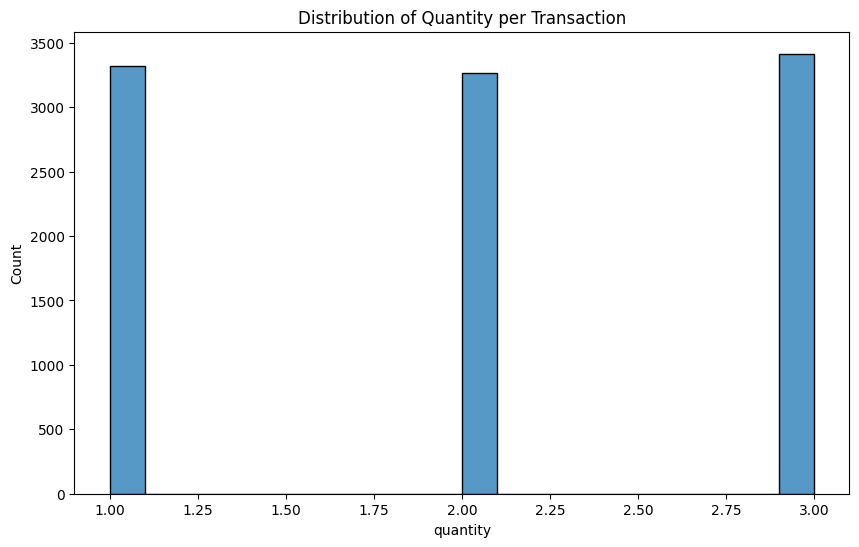

In [71]:
plt.figure(figsize=(10,6))
sns.histplot(df["price"], bins=30, kde=True)
plt.title("Distribution of Product Prices")
plt.show()

plt.figure(figsize=(10,6))
sns.histplot(df["quantity"], bins=20, kde=False)
plt.title("Distribution of Quantity per Transaction")
plt.show()

# 7. Customer Behavior

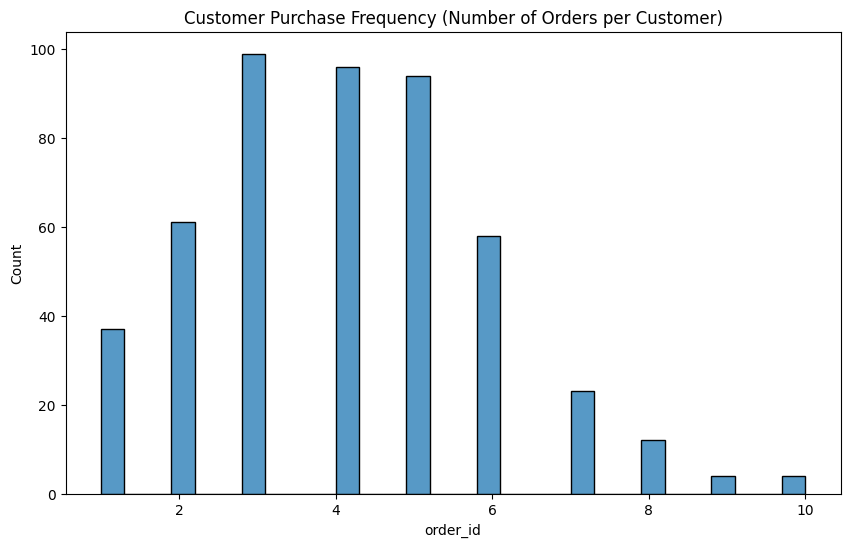

In [72]:
cust_orders = df.groupby("user_id")["order_id"].nunique()
plt.figure(figsize=(10,6))
sns.histplot(cust_orders, bins=30, kde=False)
plt.title("Customer Purchase Frequency (Number of Orders per Customer)")
plt.show()

# 8. Market Basket Preview (Co-occurrence)

In [73]:
from itertools import combinations
from collections import Counter

basket_df = df.groupby("order_id")["product_name"].apply(list)
pairs = Counter()

for items in basket_df:
    for combo in combinations(set(items), 2):
        pairs[combo] += 1

print("\nTop Product Pairs (Co-occurrence):")
print(pairs.most_common(10))


Top Product Pairs (Co-occurrence):
[(('Butter', 'Milk'), 19), (('Saree', 'Cooking Oil'), 18), (('Beef', 'Energy Drink'), 17), (('Earphones', 'Detergent'), 17), (('Cheese', 'Chips'), 17), (('Bread', 'Pastry'), 17), (('Face Wash', 'Energy Drink'), 16), (('Biscuits', 'Chicken Breast'), 16), (('Bread', 'Potato'), 16), (('Saree', 'Electric Kettle'), 16)]


In [88]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import collect_list
from pyspark.ml.fpm import FPGrowth

In [89]:
spark = SparkSession.builder.appName("BasketAnalysis").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

In [90]:
data = spark.read.csv("/content/Retail_pos_basket_data.csv.csv", header=True, inferSchema=True)

In [91]:
data = data.filter(data.order_id.isNotNull() & data.product_name.isNotNull() & data.category.isNotNull())

In [92]:
from pyspark.sql.functions import collect_set

item_baskets = data.groupBy("order_id").agg(collect_set("product_name").alias("items"))

In [93]:
from pyspark.sql.functions import collect_set

baskets = data.groupBy("order_id").agg(collect_set("product_name").alias("items"))

In [94]:
fp_growth = FPGrowth(
    itemsCol="items",
    minSupport=0.01,
    minConfidence=0.3
)

In [95]:
model = fp_growth.fit(baskets)

In [96]:
item_model = fp_growth.fit(item_baskets)

In [97]:
frequent_itemsets = model.freqItemsets
frequent_itemsets.show(10, truncate=False)

association_rules = model.associationRules
association_rules.show(10, truncate=False)

+---------------+----+
|items          |freq|
+---------------+----+
|[Pastry]       |147 |
|[Lentils]      |141 |
|[Pain Reliever]|137 |
|[Juice]        |130 |
|[Cheese]       |143 |
|[Sugar]        |135 |
|[Fiction Book] |125 |
|[Tomato]       |142 |
|[Baby Food]    |151 |
|[Milk]         |155 |
+---------------+----+
only showing top 10 rows

+----------+----------+----------+----+-------+
|antecedent|consequent|confidence|lift|support|
+----------+----------+----------+----+-------+
+----------+----------+----------+----+-------+



In [98]:
baskets = data.groupBy("order_id").agg(collect_list("category").alias("items"))

In [99]:
item_model = fp_growth.fit(item_baskets)

In [100]:
category_fp = FPGrowth(
    itemsCol="items",
    minSupport=0.01,  # You can adjust these parameters as needed
    minConfidence=0.3 # You can adjust these parameters as needed
)

In [103]:
# Fit the model
category_model = category_fp.fit(category_baskets)

In [104]:
# Extract frequent itemsets
category_frequent = category_model.freqItemsets
print("Category-Level Frequent Itemsets (Top 10):")
category_frequent.show(10, truncate=False)

Category-Level Frequent Itemsets (Top 10):
+--------------------------------------------------------------------+----+
|items                                                               |freq|
+--------------------------------------------------------------------+----+
|[Meat & Seafood]                                                    |523 |
|[Meat & Seafood, Bakery]                                            |156 |
|[Meat & Seafood, Bakery, Fruits & Vegetables]                       |60  |
|[Meat & Seafood, Bakery, Fruits & Vegetables, Grains & Staples]     |27  |
|[Meat & Seafood, Bakery, Grains & Staples]                          |64  |
|[Meat & Seafood, Electronics]                                       |135 |
|[Meat & Seafood, Electronics, Bakery]                               |40  |
|[Meat & Seafood, Electronics, Beverages]                            |44  |
|[Meat & Seafood, Electronics, Fruits & Vegetables]                  |53  |
|[Meat & Seafood, Electronics, Fruits & Veget

In [105]:
# Extract association rules
category_rules = category_model.associationRules
print("Category-Level Association Rules (Top 10):")
category_rules.show(10, truncate=False)

Category-Level Association Rules (Top 10):
+--------------------------------------------+---------------------+-------------------+------------------+--------------------+
|antecedent                                  |consequent           |confidence         |lift              |support             |
+--------------------------------------------+---------------------+-------------------+------------------+--------------------+
|[Bakery]                                    |[Fruits & Vegetables]|0.3898305084745763 |0.8614345642318328|0.1270718232044199  |
|[Bakery]                                    |[Grains & Staples]   |0.45454545454545453|0.9658484525080042|0.14816675037669513 |
|[Bakery]                                    |[Beverages]          |0.3066255778120185 |0.958385440225634 |0.09994977398292315 |
|[Beverages, Bakery, Fruits & Vegetables]    |[Grains & Staples]   |0.4225352112676056 |0.8978309558525109|0.015067805123053743|
|[Personal Care, Beverages, Grains & Staples]|[Fruits 

In [106]:


# Save category-level results

# Convert array columns to strings before saving to CSV
from pyspark.sql.functions import col, concat_ws

category_frequent_string = category_frequent.withColumn("items_string", concat_ws(",", col("items"))).drop("items")

category_rules_string = category_rules.withColumn("antecedent_string", concat_ws(",", col("antecedent"))).drop("antecedent")
category_rules_string = category_rules_string.withColumn("consequent_string", concat_ws(",", col("consequent"))).drop("consequent")
category_rules_string = category_rules_string.drop("antecedent", "consequent") # Drop original array columns if they still exist


category_frequent_string.write.csv("category_frequent_itemsets_output", header=True, mode="overwrite")
category_rules_string.write.csv("category_association_rules_output", header=True, mode="overwrite")